In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import coo_matrix
import os

## Evaluation or scoring?

eval = False

# Input data files are available in the "../input/" directory.
file = []
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #file.append(os.path.join(dirname, filename))
# print(file)

In [3]:
# Visualize rows/columns stats
def list_ID_stats(ID_list, label):
    ID_list = list(map(int, ID_list))
    list_length = len(ID_list)
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    repetitions = list_length - unique_val
    delta = max_val - min_val
    missing_val = 0.
    if delta is not 0:
        missing_val = 1 - min(unique_val, delta)/delta

    print("{} data, ID: min {}, max {}, length {}, unique {}, repetitions {}, missig {:.2f} %".format(label, min_val, max_val, list_length, unique_val, repetitions, missing_val*100))


In [4]:
# This function loads CSV files to COOrdinate formatted sparse matrixes
def toCoo(filepath, rowsDesc, columnsDesc):
    rows = []
    columns = []
    data = []
    with open(filepath) as csv_file:
        csv_reader = csv.reader(csv_file)
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                rows.append(row[0])
                columns.append(row[1])
                data.append(row[2])
                line_count += 1
    print(filepath)
    list_ID_stats(rows, rowsDesc)
    list_ID_stats(columns, columnsDesc)
    print(
    )
    data = np.array(data).astype(np.float)
    rows = np.array(rows).astype(np.int)
    columns = np.array(columns).astype(np.int)
    return coo_matrix((data, (rows, columns)))

# This function loads CSV files to NParrays
def toNPArray(filepath):
    users = []
    with open(filepath) as csv_file:
        csv_reader = csv.reader(csv_file)
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                users.append(row[0])
                line_count += 1
    users = np.array(users).astype(np.int)
    return users

In [5]:
# Loading from CSV files...
UCM_age = toCoo('data_UCM_age.csv', 'user', 'age')
ICM_subclass = toCoo('data_ICM_sub_class.csv', 'item', 'subclass')
ICM_asset = toCoo('data_ICM_asset.csv', 'item', 'asset')
ICM_price = toCoo('data_ICM_price.csv', 'item', 'price')
UCM_region = toCoo('data_UCM_region.csv', 'user', 'region')
target_users = toNPArray('data_target_users_test.csv')
URM = toCoo('data_train.csv', 'user', 'item')

data_UCM_age.csv
user data, ID: min 2, max 30909, length 30317, unique 30317, repetitions 0, missig 1.91 %
age data, ID: min 1, max 10, length 30317, unique 10, repetitions 30307, missig 0.00 %

data_ICM_sub_class.csv
item data, ID: min 0, max 18494, length 18495, unique 18495, repetitions 0, missig 0.00 %
subclass data, ID: min 1, max 2010, length 18495, unique 1905, repetitions 16590, missig 5.18 %

data_ICM_asset.csv
item data, ID: min 0, max 18494, length 18490, unique 18490, repetitions 0, missig 0.02 %
asset data, ID: min 0, max 0, length 18490, unique 1, repetitions 18489, missig 0.00 %

data_ICM_price.csv
item data, ID: min 0, max 18494, length 18493, unique 18493, repetitions 0, missig 0.01 %
price data, ID: min 0, max 0, length 18493, unique 1, repetitions 18492, missig 0.00 %

data_UCM_region.csv
user data, ID: min 0, max 30910, length 26609, unique 26375, repetitions 234, missig 14.67 %
region data, ID: min 0, max 7, length 26609, unique 7, repetitions 26602, missig 0.00 %


In [6]:
URM = URM.tocsr()

In [14]:
## Split dataset (train % of .9999 gives similar performance on test set and competition set)
from Notebooks_utils.data_splitter import train_test_holdout
URM_train, URM_test = train_test_holdout(URM, train_perc = 0.8)

In [52]:
## SLIM BPR Recommender - MAP 0.41 on test set
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Base.Evaluation.Evaluator import EvaluatorHoldout
import matplotlib.pyplot as pyplot
%matplotlib inline  
slim_rec = SLIM_BPR_Cython(URM_train, recompile_cython=False, verbose = False)
MAP_LIST = []
epochsList = [300]
batchSize = [50]
tklist = [10]
lrs = [1e-3]

for epochsN in epochsList:
    for bs in batchSize:
        for tk in tklist:
            for lr in lrs:
                slim_rec.fit(epochs=epochsN, batch_size=bs, sgd_mode='adagrad', learning_rate=lr, topK = tk)
                evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])
                dict_scores = (evaluator_validation.evaluateRecommender(slim_rec))[0][10]
                MAP_LIST.append(('epoch, batch, topK, lr :' + str(epochsN) + ' ' + str(bs)+ ' ' + str(tk) + ' ' + str(lr), dict_scores['MAP']))
MAP_LIST

Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Epoch 1 of 300. Elapsed time 0.22 sec
SLIM_BPR_Recommender: Epoch 2 of 300. Elapsed time 0.44 sec
SLIM_BPR_Recommender: Epoch 3 of 300. Elapsed time 0.55 sec
SLIM_BPR_Recommender: Epoch 4 of 300. Elapsed time 0.63 sec
SLIM_BPR_Recommender: Epoch 5 of 300. Elapsed time 0.70 sec
SLIM_BPR_Recommender: Epoch 6 of 300. Elapsed time 0.78 sec
SLIM_BPR_Recommender: Epoch 7 of 300. Elapsed time 0.85 sec
SLIM_BPR_Recommender: Epoch 8 of 300. Elapsed time 0.92 sec
SLIM_BPR_Recommender: Epoch 9 of 300. Elapsed time 0.99 sec
SLIM_BPR_Recommender: Epoch 10 of 300. Elapsed time 1.05 sec
SLIM_BPR_Recommender: Epoch 11 of 300. Elapsed time 1.12 sec
SLIM_BPR_Recommender: Epoch 12 of 300. Elapsed time 1.19 sec
SLIM_BPR_Recommender: Epoch 13 of 300. Elapsed time 1.25 sec
SLIM_BPR_Recommender: Epoch 14 of 300. Elapsed time 1.32 sec
SLIM_BPR_Recommender: Epoch 15 of 300. Elapsed time 1.39 sec
SLIM_BPR_Recommender: Epoch 16 of 300. E

SLIM_BPR_Recommender: Epoch 134 of 300. Elapsed time 10.25 sec
SLIM_BPR_Recommender: Epoch 135 of 300. Elapsed time 10.35 sec
SLIM_BPR_Recommender: Epoch 136 of 300. Elapsed time 10.44 sec
SLIM_BPR_Recommender: Epoch 137 of 300. Elapsed time 10.53 sec
SLIM_BPR_Recommender: Epoch 138 of 300. Elapsed time 10.66 sec
SLIM_BPR_Recommender: Epoch 139 of 300. Elapsed time 10.73 sec
SLIM_BPR_Recommender: Epoch 140 of 300. Elapsed time 10.83 sec
SLIM_BPR_Recommender: Epoch 141 of 300. Elapsed time 10.93 sec
SLIM_BPR_Recommender: Epoch 142 of 300. Elapsed time 11.00 sec
SLIM_BPR_Recommender: Epoch 143 of 300. Elapsed time 11.06 sec
SLIM_BPR_Recommender: Epoch 144 of 300. Elapsed time 11.13 sec
SLIM_BPR_Recommender: Epoch 145 of 300. Elapsed time 11.19 sec
SLIM_BPR_Recommender: Epoch 146 of 300. Elapsed time 11.26 sec
SLIM_BPR_Recommender: Epoch 147 of 300. Elapsed time 11.33 sec
SLIM_BPR_Recommender: Epoch 148 of 300. Elapsed time 11.39 sec
SLIM_BPR_Recommender: Epoch 149 of 300. Elapsed time 11

SLIM_BPR_Recommender: Epoch 265 of 300. Elapsed time 22.10 sec
SLIM_BPR_Recommender: Epoch 266 of 300. Elapsed time 22.17 sec
SLIM_BPR_Recommender: Epoch 267 of 300. Elapsed time 22.23 sec
SLIM_BPR_Recommender: Epoch 268 of 300. Elapsed time 22.28 sec
SLIM_BPR_Recommender: Epoch 269 of 300. Elapsed time 22.34 sec
SLIM_BPR_Recommender: Epoch 270 of 300. Elapsed time 22.40 sec
SLIM_BPR_Recommender: Epoch 271 of 300. Elapsed time 22.48 sec
SLIM_BPR_Recommender: Epoch 272 of 300. Elapsed time 22.55 sec
SLIM_BPR_Recommender: Epoch 273 of 300. Elapsed time 22.61 sec
SLIM_BPR_Recommender: Epoch 274 of 300. Elapsed time 22.68 sec
SLIM_BPR_Recommender: Epoch 275 of 300. Elapsed time 22.74 sec
SLIM_BPR_Recommender: Epoch 276 of 300. Elapsed time 22.84 sec
SLIM_BPR_Recommender: Epoch 277 of 300. Elapsed time 22.93 sec
SLIM_BPR_Recommender: Epoch 278 of 300. Elapsed time 23.05 sec
SLIM_BPR_Recommender: Epoch 279 of 300. Elapsed time 23.14 sec
SLIM_BPR_Recommender: Epoch 280 of 300. Elapsed time 23

[('epoch, batch, topK, lr :300 50 10 0.001', 0.04223990576628148)]

In [50]:
## ItemCFKNNRecommender - MAP 0.47 on test set
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemKNN = ItemKNNCFRecommender(URM_train)
itemKNN.fit(shrink=8, topK=12)
evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])
evaluator_validation.evaluateRecommender(itemKNN)

ItemKNNCFRecommender: URM Detected 4325 (13.99 %) cold users.
ItemKNNCFRecommender: URM Detected 3683 (19.91 %) cold items.
Similarity column 18495 ( 100 % ), 7186.49 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 20398 ( 100.00% ) in 11.30 sec. Users per second: 1805


({10: {'ROC_AUC': 0.16186073136644166,
   'PRECISION': 0.028233160113738564,
   'PRECISION_RECALL_MIN_DEN': 0.0834837332324828,
   'RECALL': 0.081745124985247,
   'MAP': 0.046351452413734125,
   'MRR': 0.12268098957725389,
   'NDCG': 0.07124929254777246,
   'F1': 0.04197052536596313,
   'HIT_RATE': 0.2823316011373664,
   'ARHR': 0.1345591965910134,
   'RMSE': 0.9751959096683952,
   'NOVELTY': 0.0070565171845241356,
   'AVERAGE_POPULARITY': 0.19387520731802727,
   'DIVERSITY_MEAN_INTER_LIST': 0.9895873019205885,
   'DIVERSITY_HERFINDAHL': 0.9989538787982853,
   'COVERAGE_ITEM': 0.6662341173290078,
   'COVERAGE_USER': 0.6598945359257222,
   'DIVERSITY_GINI': 0.2672410056670122,
   'SHANNON_ENTROPY': 11.557873862237301}},
 'CUTOFF: 10 - ROC_AUC: 0.1618607, PRECISION: 0.0282332, PRECISION_RECALL_MIN_DEN: 0.0834837, RECALL: 0.0817451, MAP: 0.0463515, MRR: 0.1226810, NDCG: 0.0712493, F1: 0.0419705, HIT_RATE: 0.2823316, ARHR: 0.1345592, RMSE: 0.9751959, NOVELTY: 0.0070565, AVERAGE_POPULARITY:

In [48]:
from Base.BaseSimilarityMatrixRecommender import BaseSimilarityMatrixRecommender
class ItemKNNScoresHybridRecommender(BaseSimilarityMatrixRecommender):
    """ ItemKNNScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNScoresHybridRecommender"


    def __init__(self, URM_train, Recommender_1, Recommender_2):
        super(ItemKNNScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.Recommender_1 = Recommender_1
        self.Recommender_2 = Recommender_2
        
        
    def fit(self, alpha = 0.5):

        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.Recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.Recommender_2._compute_item_score(user_id_array)
        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)
        
        
        return item_weights

In [49]:
## HYBRID: KNN + SLIM BPR
hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, itemKNN, slim_rec)
hybridrecommender.fit(alpha = 0.85)
evaluator_validation.evaluateRecommender(hybridrecommender)

ItemKNNScoresHybridRecommender: URM Detected 4325 (13.99 %) cold users.
ItemKNNScoresHybridRecommender: URM Detected 3683 (19.91 %) cold items.
EvaluatorHoldout: Processed 20398 ( 100.00% ) in 12.24 sec. Users per second: 1667


({10: {'ROC_AUC': 0.16298615293749485,
   'PRECISION': 0.028360623590550065,
   'PRECISION_RECALL_MIN_DEN': 0.08396658480367636,
   'RECALL': 0.08224327113640985,
   'MAP': 0.046486558670415304,
   'MRR': 0.1230631076498318,
   'NDCG': 0.07155539540672393,
   'F1': 0.04217700400719661,
   'HIT_RATE': 0.28360623590548095,
   'ARHR': 0.13500436550735592,
   'RMSE': 0.9778762642346267,
   'NOVELTY': 0.007006254448220691,
   'AVERAGE_POPULARITY': 0.20026565018110837,
   'DIVERSITY_MEAN_INTER_LIST': 0.9899238737398554,
   'DIVERSITY_HERFINDAHL': 0.9989875343301884,
   'COVERAGE_ITEM': 0.6861854555285212,
   'COVERAGE_USER': 0.6598945359257222,
   'DIVERSITY_GINI': 0.2644025833595039,
   'SHANNON_ENTROPY': 11.579551844992963}},
 'CUTOFF: 10 - ROC_AUC: 0.1629862, PRECISION: 0.0283606, PRECISION_RECALL_MIN_DEN: 0.0839666, RECALL: 0.0822433, MAP: 0.0464866, MRR: 0.1230631, NDCG: 0.0715554, F1: 0.0421770, HIT_RATE: 0.2836062, ARHR: 0.1350044, RMSE: 0.9778763, NOVELTY: 0.0070063, AVERAGE_POPULARI

PureSVDRecommender: URM Detected 4300 (13.91 %) cold users.
PureSVDRecommender: URM Detected 3726 (20.15 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
TopPopRecommender: URM Detected 4300 (13.91 %) cold users.
TopPopRecommender: URM Detected 3726 (20.15 %) cold items.
Group 0, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 248 ( 100.00% ) in 0.15 sec. Users per second: 1621
EvaluatorHoldout: Processed 248 ( 100.00% ) in 0.14 sec. Users per second: 1790
EvaluatorHoldout: Processed 248 ( 100.00% ) in 0.13 sec. Users per second: 1871
EvaluatorHoldout: Processed 248 ( 100.00% ) in 0.18 sec. Users per second: 1403
Group 1, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 205 ( 100.00% ) in 0.15 sec. Users per second: 1388
EvaluatorHoldout: Processed 205 ( 100.00% ) in 0.12 sec. Users per second: 1676
EvaluatorHol

EvaluatorHoldout: Processed 1545 ( 100.00% ) in 1.34 sec. Users per second: 1149
EvaluatorHoldout: Processed 1545 ( 100.00% ) in 1.10 sec. Users per second: 1401
EvaluatorHoldout: Processed 1545 ( 100.00% ) in 1.14 sec. Users per second: 1358


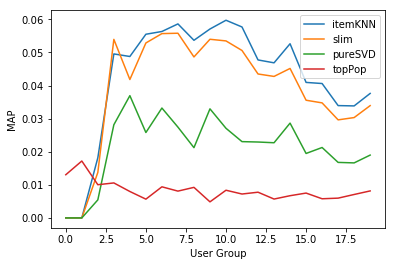

In [45]:

## TEST & VISUALIZE DIFFERENT RECSYS PERFORMANCE BASED ON N° OF INTERACTIONS HELD BY USERS
URM_train = sps.csr_matrix(URM_train)

profile_length = np.ediff1d(URM_train.indptr)
block_size = int(len(profile_length)*0.05)
sorted_users = np.argsort(profile_length)
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

from Base.NonPersonalizedRecommender import TopPop
topPop = TopPop(URM_train)
topPop.fit()

MAP_itemKNN_per_group = []
MAP_slim_per_group = []
MAP_pureSVD_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    
    results, _ = evaluator_test.evaluateRecommender(itemKNN)
    MAP_itemKNN_per_group.append(results[cutoff]["MAP"])
 
    results, _ = evaluator_test.evaluateRecommender(pureSVD)
    MAP_pureSVD_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(slim_rec)
    MAP_slim_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])
    
    
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_itemKNN_per_group, label="itemKNN")
pyplot.plot(MAP_slim_per_group, label="slim")
pyplot.plot(MAP_pureSVD_per_group, label="pureSVD")
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()


In [40]:
output = []
for user_id in target_users:
    output.append((user_id, hybridrecommender.recommend(user_id, cutoff=10)))

In [41]:
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["user_id", "item_list"])
    for row in output:
      ranking = ''
      for val in row[1]:
        ranking = ranking + str(val) + ' '
      writer.writerow([row[0], ranking[:-1]])